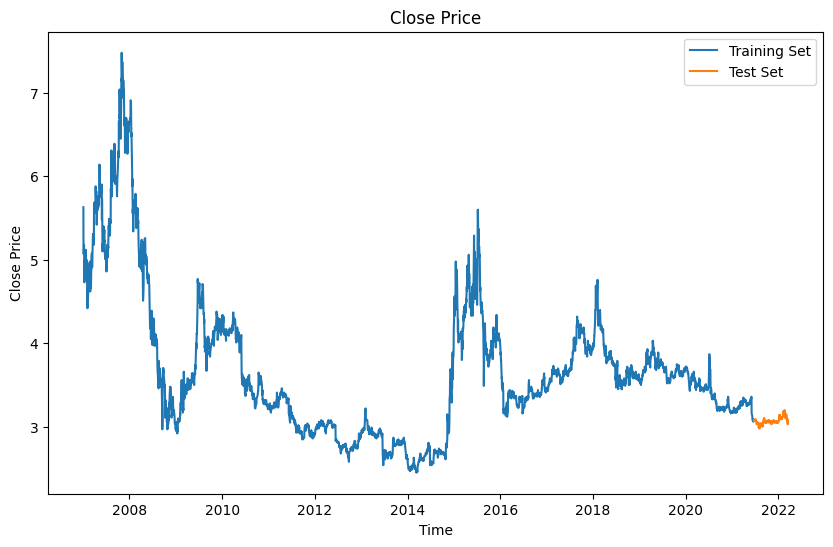

<ipython-input-7-1a574b7c6d5f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_1'] = training_set['close'].diff()
<ipython-input-7-1a574b7c6d5f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_2'] = training_set['diff_1'].diff()


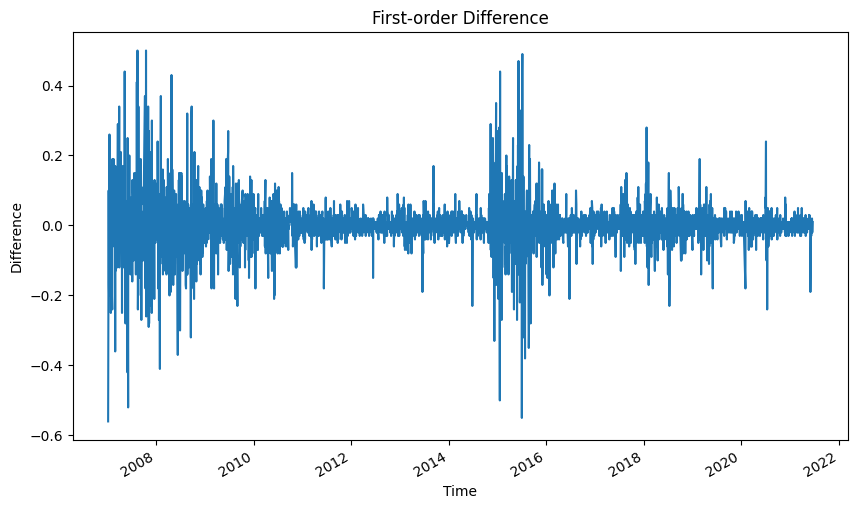

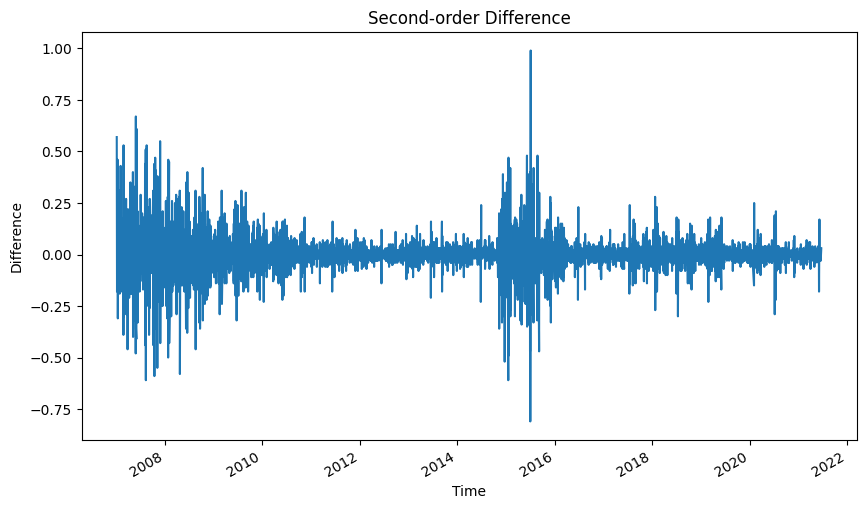

Ljung-Box test:      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1   3.458346   0.062933   3.455383   0.063046
2  23.695323   0.000007  23.669246   0.000007


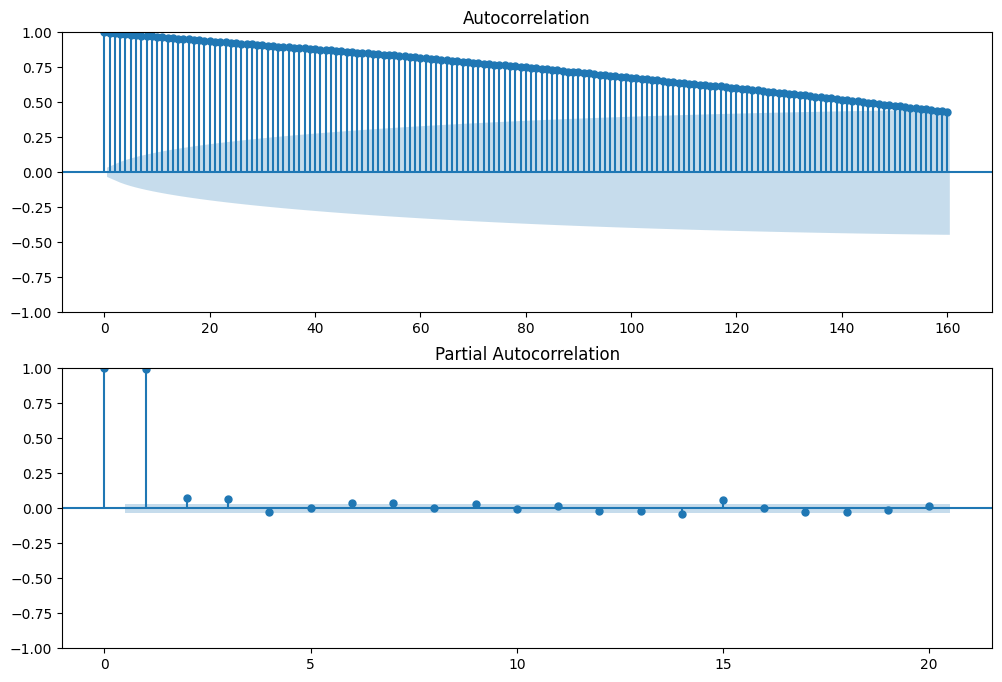

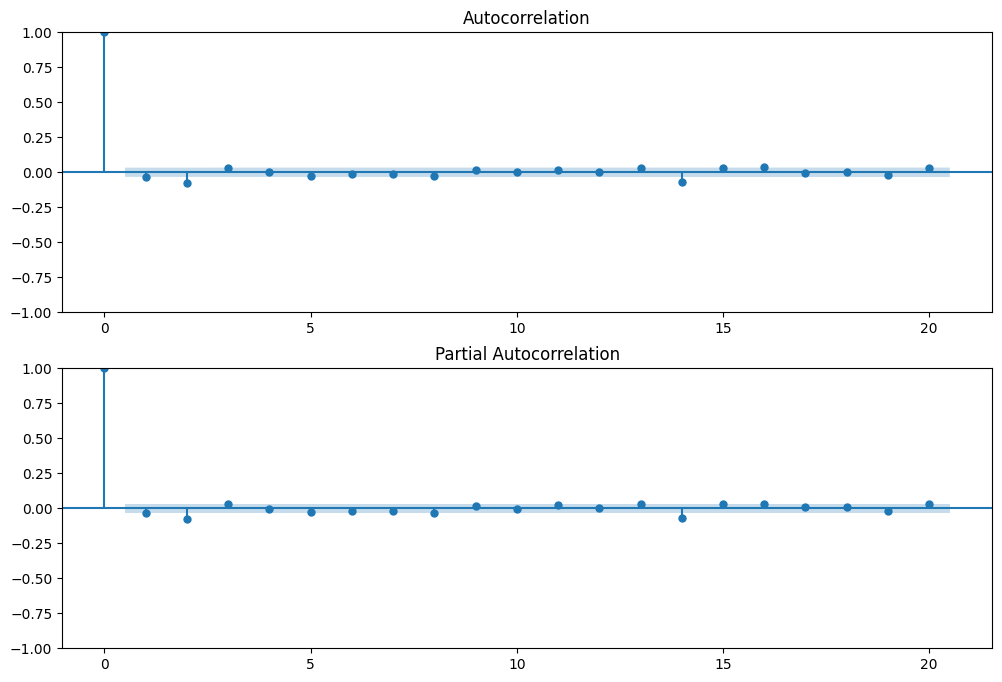

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


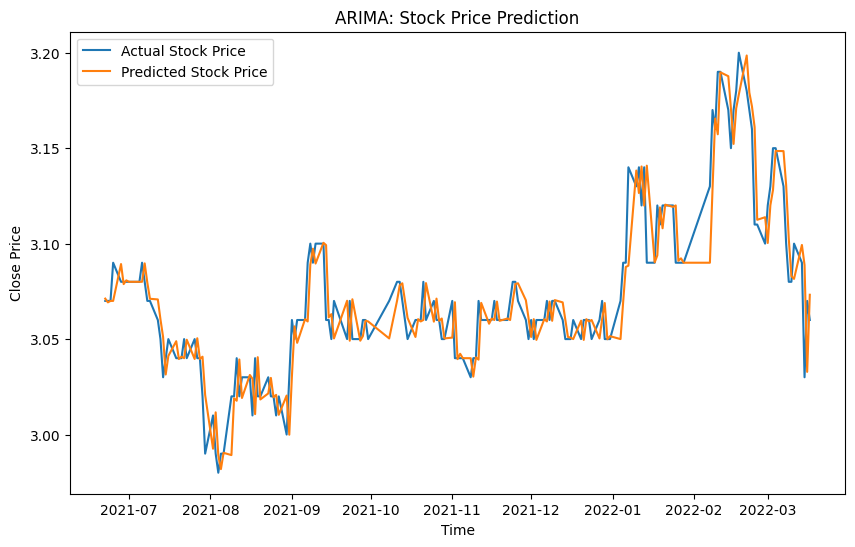

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


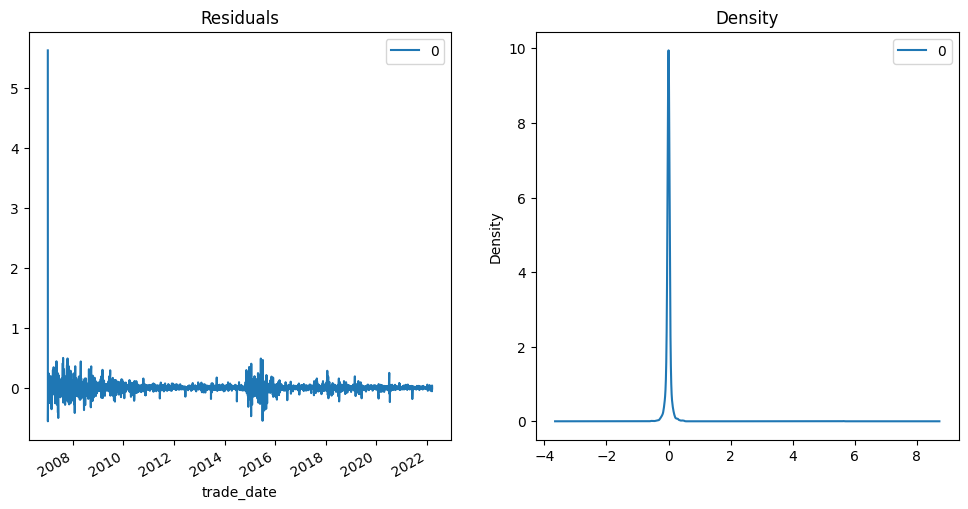

MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84439
                                value
Test Statistic Value        -2.355387
p-value                      0.154726
Lags Used                          16
Number of Observations Used      3484
Critical Value(1%)          -3.432228
Critical Value(5%)           -2.86237
Critical Value(10%)         -2.567212


/content/utils.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  output['value']['Test Statistic Value'] = t[0]
/content/utils.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values throu

                                 value
Test Statistic Value        -14.749755
p-value                            0.0
Lags Used                           15
Number of Observations Used       3484
Critical Value(1%)           -3.432228
Critical Value(5%)            -2.86237
Critical Value(10%)          -2.567212


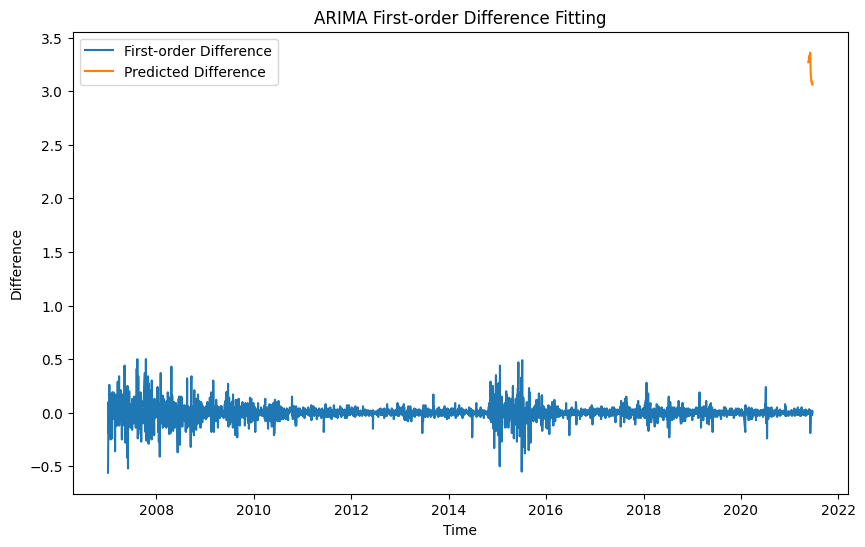

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from utils import acf_pacf_plot, evaluation_metric, adf_test

# Load data
data = pd.read_csv('./601988.SH.csv')
test_set2 = data.loc[3501:, :]
data.index = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data = data.drop(['ts_code', 'trade_date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

# Split data into training and test sets
training_set = data.loc['2007-01-04':'2021-06-21', :]  # 3501 entries for training
test_set = data.loc['2021-06-22':, :]  # 180 entries for testing

# Plot the close price
plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='Training Set')
plt.plot(test_set['close'], label='Test Set')
plt.title('Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate first-order and second-order differences
training_set['diff_1'] = training_set['close'].diff()
training_set['diff_2'] = training_set['diff_1'].diff()

# Plot first-order difference
plt.figure(figsize=(10, 6))
training_set['diff_1'].plot()
plt.title('First-order Difference')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

# Plot second-order difference
plt.figure(figsize=(10, 6))
training_set['diff_2'].plot()
plt.title('Second-order Difference')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

# White noise test
temp2 = np.diff(training_set['close'].dropna(), n=1)
print("Ljung-Box test:", acorr_ljungbox(temp2, lags=2, boxpierce=True))

# Plot ACF and PACF
acf_pacf_plot(training_set['close'].dropna(), acf_lags=160)

# Prepare data for ARIMA modeling
data2 = {
    'trade_date': training_set['diff_1'].index[1:],
    'close': list(temp2)
}
df = pd.DataFrame(data2).set_index('trade_date')

# Plot ACF and PACF of first-order differenced data
acf_pacf_plot(df['close'])

# Fit ARIMA model
model = ARIMA(endog=training_set['close'], order=(2, 1, 0)).fit()

# Forecast using ARIMA model
history = training_set['close'].tolist()
predictions = []
for t in range(len(test_set)):
    model1 = ARIMA(history, order=(2, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test_set2.iloc[t, 5]
    history.append(obs)

# Save and plot predictions
predictions1 = pd.DataFrame({
    'trade_date': test_set.index,
    'close': predictions
}).set_index('trade_date')
predictions1.to_csv('./ARIMA.csv')

plt.figure(figsize=(10, 6))
plt.plot(test_set['close'], label='Actual Stock Price')
plt.plot(predictions1['close'], label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

model2 = ARIMA(endog=data['close'], order=(2, 1, 0)).fit()

residuals = pd.DataFrame(model2.resid)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
residuals.to_csv('./ARIMA_residuals1.csv')

# Evaluate model
evaluation_metric(test_set['close'], predictions)

# ADF tests for stationarity
adf_test(training_set['close'].values)
adf_test(temp2)

# Plot first-order difference fitting
predictions_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)
predictions_ARIMA_diff = predictions_ARIMA_diff[3479:]

plt.figure(figsize=(10, 6))
plt.plot(training_set['diff_1'], label="First-order Difference")
plt.plot(predictions_ARIMA_diff, label="Predicted Difference")
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('ARIMA First-order Difference Fitting')
plt.legend()
plt.show()


In [8]:
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from utils import *
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, Permute, Lambda, Flatten, RepeatVector
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Reshape
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

def attention_3d_block_Concatenate(inputs,single_attention_vector = False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = Concatenate([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

# Attention block function
def attention_3d_block(inputs, single_attention_vector=False):
    # Get the input shape (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]

    # Apply Dense layer to produce the attention weights
    a = Dense(input_dim, activation='softmax')(inputs)

    if single_attention_vector:

        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(time_steps)(a)
    else:
        # Directly reshape the attention to match the input for multiplication
        a = Reshape((time_steps, input_dim))(a)

    # Multiply attention weights with inputs
    output_attention_mul = Multiply()([inputs, a])
    return output_attention_mul

# Define the attention-based model architecture
def attention_model(INPUT_DIMS=13, TIME_STEPS=20, lstm_units=64):
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

# Prediction function using provided data
def PredictWithData(data, data_yuan, name, modelname, INPUT_DIMS=13, TIME_STEPS=20):
    print(data.columns)
    yindex = data.columns.get_loc(name)
    data = np.array(data, dtype='float64')
    data, normalize = NormalizeMult(data)
    data_y = data[:, yindex].reshape(-1, 1)

    testX, _ = create_dataset(data)
    _, testY = create_dataset(data_y)
    print("testX Y shape is:", testX.shape, testY.shape)

    if len(testY.shape) == 1:
        testY = testY.reshape(-1, 1)

    model = attention_model(INPUT_DIMS)
    model.load_weights(modelname)
    model.summary()
    y_hat = model.predict(testX)
    testY, y_hat = xgb_scheduler(data_yuan, y_hat)
    return y_hat, testY

# LSTM model variants for different configurations
def lstm(model_type, X_train, yX_train):
    if model_type == 1:
        # Single-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(units=1))

        ymodel = Sequential()
        ymodel.add(LSTM(units=50, activation='relu', input_shape=(yX_train.shape[1], 5)))
        ymodel.add(Dense(units=5))

    elif model_type == 2:
        # Multi-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dense(1))

        ymodel = Sequential()
        ymodel.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(yX_train.shape[1], 5)))
        ymodel.add(LSTM(units=50, activation='relu'))
        ymodel.add(Dense(5))

    elif model_type == 3:
        # BiLSTM
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))

        ymodel = Sequential()
        ymodel.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(yX_train.shape[1], 5)))
        ymodel.add(Dense(5))

    return model, ymodel

# XGBoost helper function to prepare and validate data
def xgb_scheduler(data, y_hat):
    close = data.pop('close')
    data.insert(5, 'close', close)
    train, test = prepare_data(data, n_test=len(y_hat), n_in=6, n_out=1)
    testY, y_hat2 = walk_forward_validation(train, test)
    return testY, y_hat2

def xgboost_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20)
    model.fit(trainX, trainy)
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

# Walk-forward validation
def walk_forward_validation(train, test):
    predictions = []
    train = train.values
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        yhat = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i, :])
        print(i+1, '>expected=%.6f, predicted=%.6f' % (testy, yhat))
    return test.iloc[:, -1], predictions

data1 = pd.read_csv("./601988.SH.csv")
data1.index = pd.to_datetime(data1['trade_date'], format='%Y%m%d')
data1 = data1.loc[:, ['open', 'high', 'low', 'close', 'vol', 'amount']]
data_yuan = data1
residuals = pd.read_csv('./ARIMA_residuals1.csv')
residuals.index = pd.to_datetime(residuals['trade_date'])
residuals.pop('trade_date')
data1 = pd.merge(data1, residuals, on='trade_date')
data = data1.iloc[1:3500, :]
data2 = data1.iloc[3500:, :]

TIME_STEPS = 20

data, normalize = NormalizeMult(data)
print('#', normalize)
pollution_data = data[:, 3].reshape(len(data), 1)

train_X, _ = create_dataset(data, TIME_STEPS)
_, train_Y = create_dataset(pollution_data, TIME_STEPS)

print(train_X.shape, train_Y.shape)

m = attention_model(INPUT_DIMS=7,TIME_STEPS=20, lstm_units=64)
m.summary()
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse')
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.1)
m.save("./stock_model.keras")
np.save("stock_normalize.npy", normalize)



(7, 2)
# [[ 2.46000000e+00  7.40000000e+00]
 [ 2.46000000e+00  7.58000000e+00]
 [ 2.44000000e+00  7.23000000e+00]
 [ 2.45000000e+00  7.48000000e+00]
 [ 5.67951900e+04  5.10989742e+07]
 [ 1.57377550e+04  2.74651219e+07]
 [-5.59999999e-01  4.97357729e-01]]
(3478, 20, 7) (3478, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 7)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 20, 64)         │            512 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 20, 64)         │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 20, 128)        │         66,048 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 20, 128)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 20, 128)        │         16,512 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 20, 128)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 20, 128)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2560)           │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          2,561 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 85,633 (334.50 KB)

 Trainable params: 85,633 (334.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0330 - val_loss: 7.0235e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0018 - val_loss: 0.0138
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0016 - val_loss: 0.0108
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss:

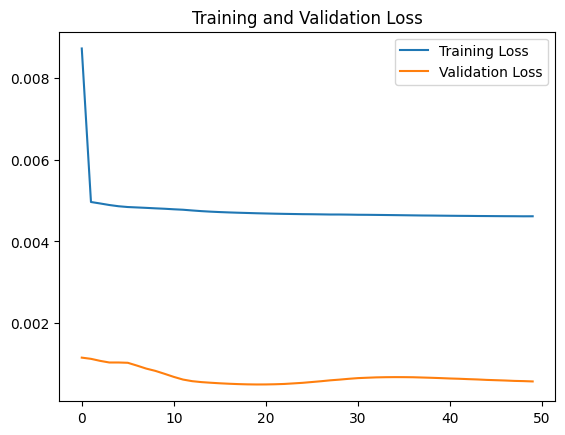

Index(['open', 'high', 'low', 'close', 'vol', 'amount', '0'], dtype='object')
(7, 2)
testX Y shape is: (160, 20, 7) (160, 1)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 20, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 20, 64)         │            512 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 20, 64)         │              0 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 20, 128)        │         66,048 │ dropout_4[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 20, 128)        │              0 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 20, 128)        │         16,512 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 20, 128)        │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 20, 128)        │              0 │ dropout_5[0][0],       │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2560)           │              0 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │          2,561 │ flatten_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 85,633 (334.50 KB)

 Trainable params: 85,633 (334.50 KB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
supervised_data       var1(t-6)  var2(t-6)  var3(t-6)   var4(t-6)    var5(t-6)  var6(t-6)  \
6          5.69       5.97       5.37  7281333.33  4224852.614       5.63   
7          5.30       5.34       5.07  7867306.84  4050377.943       5.07   
8          4.87       5.14       4.83  5565756.49  2763751.983       5.08   
9          5.06       5.19       4.95  4334458.33  2198327.249       5.18   
10         5.25       5.29       5.05  3721171.25  1915221.182       5.10   
...         ...        ...        ...         ...          ...        ...   
3676       3.13       3.16       3.13  1374157.76   432082.360       3.15   
3677       3.15       3.16       3.14  1560240.83   490908.221       3.15   
3678       3.14       3.15       3.12  1360415.16   426283.660       3.13   
3679       3.12       3.14       3.10  1500377.44   467690.817       3.10   
3680       3.10       3.11       3.04  2660491.55   820162.507       3.08   

      var1(t-5)  var

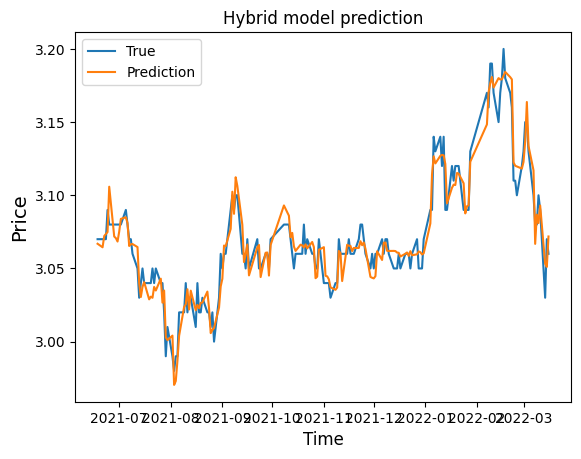

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

class Config:
    def __init__(self):
        self.dimname = 'close'

config = Config()
name = config.dimname

y_hat, y_test = PredictWithData(data2, data_yuan, name, 'stock_model.keras',7)
y_hat = np.array(y_hat, dtype='float64')
y_test = np.array(y_test, dtype='float64')
evaluation_metric(y_test,y_hat)
time = pd.Series(data1.index[3499:3499 + len(y_test)])

plt.plot(time, y_test, label='True')
plt.plot(time, y_hat, label='Prediction')
plt.title('Hybrid model prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Price', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,901 (81.64 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0211 - val_loss: 0.0012
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0050 - val_loss: 0.0010
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 9.5901e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 8.8590e-04
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 8.2943e-04
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 7.5756e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - val_loss: 6.8238e-04
Epoch 12/50
110/1

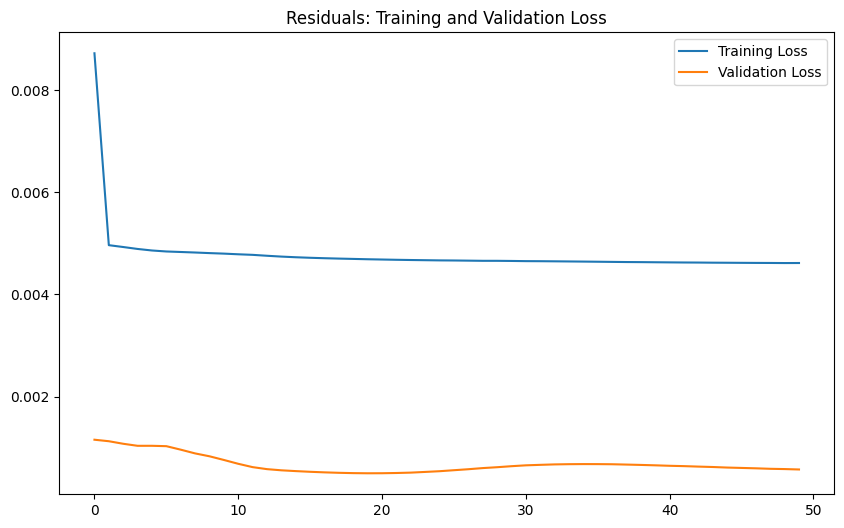

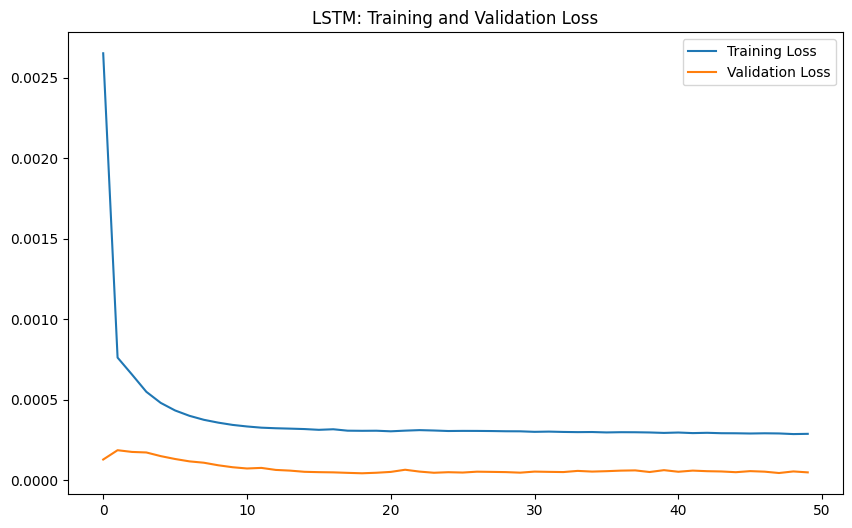

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


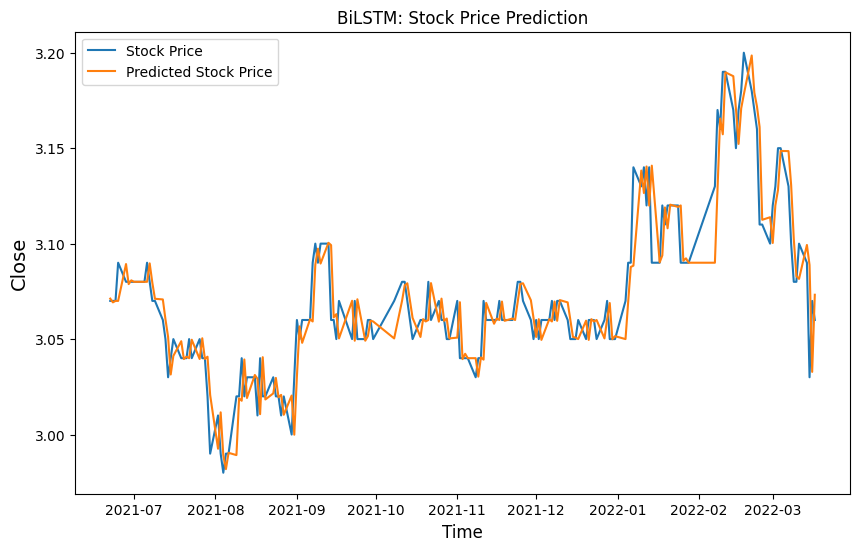

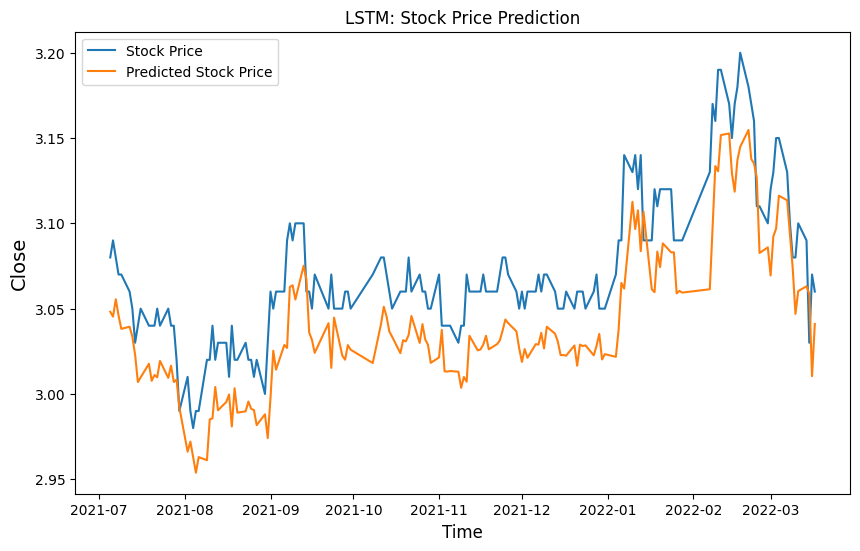

MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84235


In [10]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
from numpy.random import seed
from utils import data_split, evaluation_metric

def lstm(model_type, X_train, yX_train):
    if model_type == 1:
        # Single-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(units=1))

        ymodel = Sequential()
        ymodel.add(LSTM(units=50, activation='relu', input_shape=(yX_train.shape[1], 5)))
        ymodel.add(Dense(units=5))

    elif model_type == 2:
        # Multi-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dense(1))

        ymodel = Sequential()
        ymodel.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(yX_train.shape[1], 5)))
        ymodel.add(LSTM(units=50, activation='relu'))
        ymodel.add(Dense(5))

    elif model_type == 3:
        # BiLSTM
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))

        ymodel = Sequential()
        ymodel.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(yX_train.shape[1], 5)))
        ymodel.add(Dense(5))

    return model, ymodel

# GPU configuration
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50
model_type = 3

# Load data
ydata = pd.read_csv('./601988.SH.csv')
ydata.index = pd.to_datetime(ydata['trade_date'], format='%Y%m%d')
ydata = ydata.loc[:, ['open', 'high', 'low', 'close', 'amount']]

data = pd.read_csv('./ARIMA_residuals1.csv')
data.index = pd.to_datetime(data['trade_date'])
data = data.drop('trade_date', axis=1)

Lt = pd.read_csv('./ARIMA.csv')
idx = 3500
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
ytraining_set = ydata.iloc[1:idx, :]
ytest_set = ydata.iloc[idx:, :]

# Scale data
sc = MinMaxScaler(feature_range=(0, 1))
ysc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(test_set)
ytraining_set_scaled = ysc.fit_transform(ytraining_set)
ytesting_set_scaled = ysc.transform(ytest_set)

# Prepare training and test data
X_train, y_train = data_split(training_set_scaled, n_timestamp)
yX_train, yy_train = data_split(ytraining_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yX_train = yX_train.reshape(yX_train.shape[0], yX_train.shape[1], 5)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yX_test, yy_test = data_split(ytesting_set_scaled, n_timestamp)
yX_test = yX_test.reshape(yX_test.shape[0], yX_test.shape[1], 5)

# Build models
model, ymodel = lstm(model_type, X_train, yX_train)
print(model.summary())

# Define separate optimizers
adam_model = Adam(learning_rate=0.01)
adam_ymodel = Adam(learning_rate=0.01)

# Compile models
model.compile(optimizer=adam_model, loss='mse')
ymodel.compile(optimizer=adam_ymodel, loss='mse')

# Train models
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)

yhistory = ymodel.fit(yX_train, yy_train,
                      batch_size=32,
                      epochs=n_epochs,
                      validation_data=(yX_test, yy_test),
                      validation_freq=1)

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Residuals: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yhistory.history['loss'], label='Training Loss')
plt.plot(yhistory.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

# Predict and inverse transform
ypredicted_stock_price = ymodel.predict(yX_test)
ypredicted_stock_price = ysc.inverse_transform(ypredicted_stock_price)
ypredicted_stock_price_list = np.array(ypredicted_stock_price[:, 3]).flatten().tolist()
ypredicted_stock_price1 = pd.DataFrame({
    'trade_date': ydata.index[idx+10:],
    'close': ypredicted_stock_price_list
}).set_index(['trade_date'], drop=True)

yreal_stock_price = ysc.inverse_transform(yy_test)
yreal_stock_price_list = np.array(yreal_stock_price[:, 3]).flatten().tolist()
yreal_stock_price1 = pd.DataFrame({
    'trade_date': ydata.index[idx+10:],
    'close': yreal_stock_price_list
}).set_index(['trade_date'], drop=True)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price1 = pd.DataFrame({
    'trade_date': data.index[idx+10:],
    'close': predicted_stock_price_list
}).set_index(['trade_date'], drop=True)

real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('trade_date')['close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['trade_date'])
finalpredicted_stock_price = finalpredicted_stock_price.drop(['trade_date'], axis=1)

# Plot stock price predictions
plt.figure(figsize=(10, 6))
plt.plot(ydata.loc['2021-06-22':, 'close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['close'], label='Predicted Stock Price')
plt.title('BiLSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close', fontsize=14)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yreal_stock_price1['close'], label='Stock Price')
plt.plot(ypredicted_stock_price1['close'], label='Predicted Stock Price')
plt.title('LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close', fontsize=14)
plt.legend()
plt.show()

# Evaluate model
yhat = ydata.loc['2021-06-22':, 'close']
evaluation_metric(finalpredicted_stock_price['close'], yhat)
